Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [550]:
from random import random, seed
from itertools import product
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [551]:
# Instance 1
# UNIVERSE_SIZE = 100
# NUM_SETS = 10
# DENSITY = 0.2

# Instance 2
# UNIVERSE_SIZE = 1_000
# NUM_SETS = 100
# DENSITY = 0.2

#Instance 3
UNIVERSE_SIZE = 10_000
NUM_SETS = 1000
DENSITY = 0.2

#Instance 4
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.1

#Instance 5
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.2

# Instance 6
# UNIVERSE_SIZE = 100_000
# NUM_SETS = 10_000
# DENSITY = 0.3
N_STEPS = 20_000
REPRODUCIBILIY = False

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
if REPRODUCIBILIY:
    random_gen = rng
else:
    random_gen = np.random


In [552]:
# DON'T EDIT THESE LINES!
SETS = random_gen.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        if REPRODUCIBILIY:
            SETS[random_gen.integers(NUM_SETS), s] = True
        else:
            SETS[random_gen.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [553]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [554]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4279020.418100409))

In [555]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2137778.9910044083))

In [556]:
def tweak(solution:np.ndarray)->np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0,NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation_tweak(solution:np.ndarray)->np.ndarray:
    mask = rng.random(NUM_SETS) < MULTI_TWEAK
    new_sol = np.logical_xor(solution,mask)
    return new_sol

In [557]:
def fitness(solution:np.ndarray):
    return (valid(solution),-cost(solution))

In [558]:
used_simulated_annealing=0
accepted_invalid=0
def simulated_annealing(f_cur_sol: np.ndarray, f_tweaked_sol: np.ndarray, temperature: np.float64) -> np.float64:
    worse_p = np.exp((f_tweaked_sol - f_cur_sol) / temperature)
    global used_simulated_annealing

    is_accept = random_gen.random() <= worse_p
    if is_accept:
        used_simulated_annealing+=1
        # ic(temperature, worse_p)
    return is_accept

def accept_invalid():
     global accepted_invalid
     is_accept = random_gen.random() <= 0.03
     if(is_accept):
        accepted_invalid+=1
     return is_accept


ic| 

solution_fitness: (np.True_, np.float64(-4279020.418100409))
100%|██████████| 20000/20000 [00:02<00:00, 7078.26it/s] 
ic| history.index(best_solution): 15730
    best_solution: (np.True_, np.float64(-124789.63781142421))


Accepted worse solution (simulated annealing): 88 times
Accepted invalid solutions: 13 times


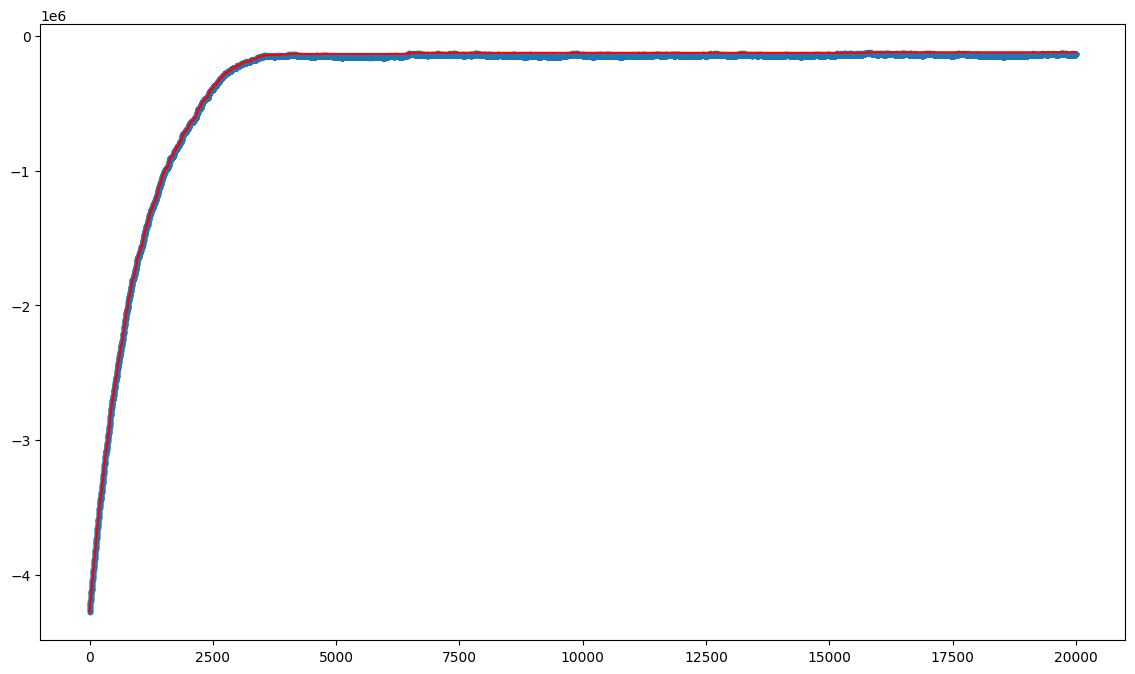

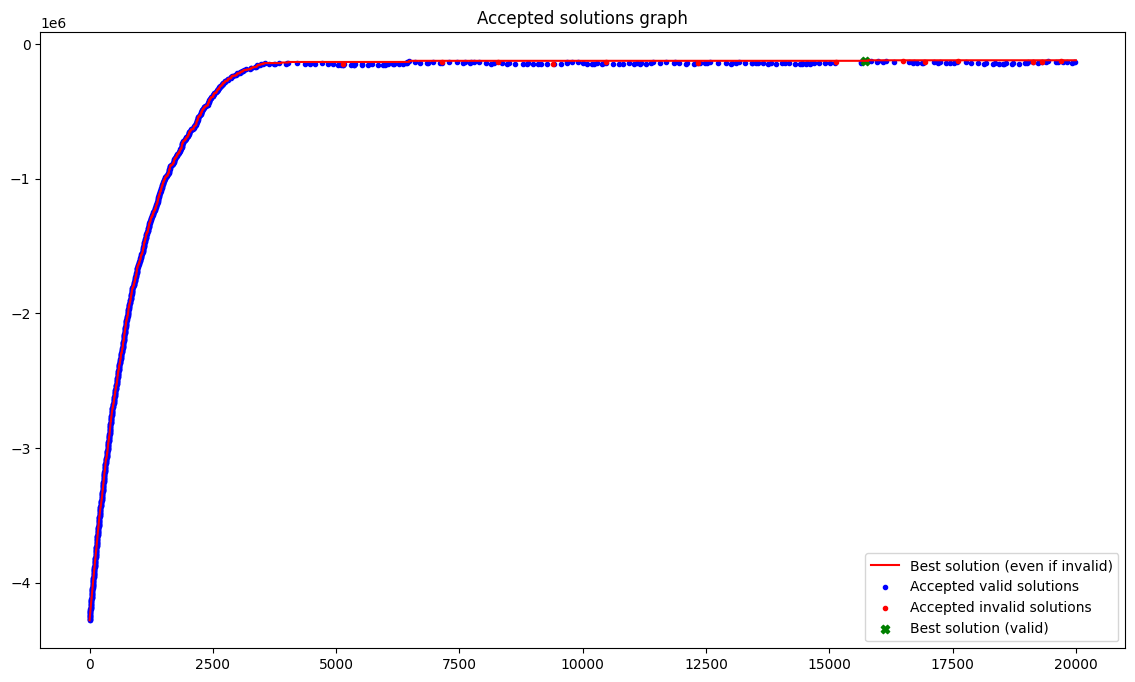

In [559]:
used_simulated_annealing=0
accepted_invalid=0
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
ic(solution_fitness)
history=[solution_fitness]
best_solution = solution_fitness
STARTING_VALUE_TEMP = 1
temperature = STARTING_VALUE_TEMP
accepted_sol_index=[0]

INC_VALUE = 10

ic.disable()
for steps in tqdm(range(N_STEPS)):
    new_solution = tweak(solution)
    f_newsol = fitness(new_solution)
    history.append(f_newsol)
    if  ((f_newsol[0] and f_newsol>solution_fitness) # if the new solution is valid and better than the current one
         or (solution_fitness[0] #or if the current solution is valid (2 invalid solutions in a row are not accepted!): 
         and (( f_newsol[0] and simulated_annealing(solution_fitness[1],f_newsol[1],temperature)) # then with a probability we accept a worse solution
         or ( not f_newsol[0] and accept_invalid())))) : # or with a probability we accept an invalid solution
        if f_newsol>best_solution:
            best_solution=f_newsol
        accepted_sol_index.append(len(history)-1)
       
        solution=new_solution
        solution_fitness =  fitness(solution)
        temperature = STARTING_VALUE_TEMP
    else:
            temperature+= INC_VALUE

ic.enable()
print("Accepted worse solution (simulated annealing):",used_simulated_annealing, "times")
print("Accepted invalid solutions:",accepted_invalid, "times")
ic(history.index(best_solution),best_solution)
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history),),
    [max(history[: i + 1], key= lambda x: x[1])[1] for i in range(len(history))],
    color="red",
)
plt.scatter(range(len(history)), [value for _, value in history], marker=".")
plt.show()

# Plotting the accepted solutions graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history),),
    [max(history[: i + 1], key= lambda x: x[1])[1] for i in range(len(history))],
    color="red",
)
plt.scatter(
    [i for i, (flag, _) in enumerate(history) if flag and i in accepted_sol_index],
    [value for i, (flag, value) in enumerate(history) if flag and i in accepted_sol_index],
    color="blue",
    marker=".",
)
plt.scatter(
    [i for i, (flag, _) in enumerate(history) if not flag and i in accepted_sol_index],
    [value for i, (flag, value) in enumerate(history) if (flag==False) and i in accepted_sol_index],
    color="red",
    marker=".",
)
plt.scatter(
    history.index(best_solution),
    best_solution[1],
    color="green",
    marker="X",
)
plt.title("Accepted solutions graph")
plt.legend(["Best solution (even if invalid)", "Accepted valid solutions", "Accepted invalid solutions", "Best solution (valid)"])
plt.show()

